In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import h5py as h5
import astropy.units as u
import warnings
import math
import seaborn as sns
import pickle

from gwpopulation.models.redshift import PowerLawRedshift
import deepdish as dd

from matplotlib import rc
from KDEpy import FFTKDE  # Fastest 1D algorithm
from   astropy.cosmology import WMAP9 as cosmology
from astropy.cosmology import z_at_value
from scipy import stats
from   scipy.optimize import newton
from scipy.optimize import curve_fit

# Import COMPAS root directory and set data
compasRootDir   = '/Users/adamboesky/Research/PRISE/COMPAS'

# Import COMPAS specific scripts
sys.path.append(compasRootDir + '/utils/CosmicIntegration/')
sys.path.append(os.getcwd() + '/Scripts')
from pickle_writers import pickle_rates_and_boostraps
import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects
import formation_channels

# Magic function to set the backend of matplotlib to the 'inline' backend
%matplotlib inline

#Set latex environment for plots/labels
# plt.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath'
plt.rcParams['text.usetex'] = True
# plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['font.sans-serif'] = 'serif'
# plt.rcParams['mathtext.fontset'] = 'stix'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_1039/1997916609.py:50: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
path_to_data = '/Volumes/T7/Research_Data/final_sigma_remnant_prescription/'

# Get paths for the data files in the $\alpha_{\textrm{CE}}$ and $\beta$ grid

In [3]:
alpha_vals = ['30', '265', '750'] # All the alpha values
beta_vals = ['D', 'M', 'R'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for velocity_dispersion in alpha_vals:
    condensed_paths[velocity_dispersion] = {}
    for remnant_mass_p in beta_vals:
        condensed_paths[velocity_dispersion][remnant_mass_p] = path_to_data+'output_sigma_'+velocity_dispersion+'_remnant_prescription_'+remnant_mass_p+'/COMPAS_Output_Weighted.h5'

# Merger Rates $R(z)$

Define parameters for the merger rate calculation

In [4]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
weight_column   = 'mixture_weight'
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 1.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 * (1 + max_redshift_detection)
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5     # * u.Msun 
m1_max          = 150   # * u.Msun
m2_min          = m1_min * 0.01 # m2_min = min(q) * min(m1)
fbin            = 1.0

# Van Son 2022 prescriptions:
mu0             = 0.025
muz             = -0.048
sigma0          = 1.125
sigmaz          = 0.048
alpha           = -1.77

aSF             = 0.02
bSF             = 1.48 
cSF             = 4.45 
dSF             = 5.9

# MY FIDUCIAL MSSFR PRESCRIPTIONS
lognormal=False                                     # !!! IF THIS PARAMETER IS FALSE, IT WILL USE THE NON-LOGNORMAL MSSFR PRESCRIPTIONS !!!
Zprescription='MZ_GSMF'
SFRprescription='Madau et al. (2017)'
GSMFprescription='Panter et al. (2004) Single'
ZMprescription='Ma et al. (2016)'
logNormalPrescription=None

In [5]:
plt.style.use('ggplot')                                                          
# rainbow_cmap = matplotlib.cm.get_cmap('rainbow')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
num_colors = len(alpha_vals)
counter = 0
color_grid = {}
marker_grid = {}
linestyle_grid = {}
for alpha_index, alpha_val in enumerate(alpha_vals):
    color_grid[alpha_val] = {}
    marker_grid[alpha_val] = {}
    linestyle_grid[alpha_val] = {}
    for beta_index, beta_val in enumerate(beta_vals):
        # color_grid[alpha_val][beta_val] = rainbow_cmap(alpha_index/num_colors)
        if alpha_index == 0:
            color_grid[alpha_val][beta_val] = colors[6]
        elif alpha_index == 1:
            color_grid[alpha_val][beta_val] = colors[3]
        else:
            color_grid[alpha_val][beta_val] = '#6085ff'

        if beta_val == 'D':
            linestyle_grid[alpha_val][beta_val] = 'solid'
            marker_grid[alpha_val][beta_val] = 'o'
        elif beta_val == 'M':
            linestyle_grid[alpha_val][beta_val] = 'dashed'
            marker_grid[alpha_val][beta_val] = '^'
        elif beta_val == 'R':
            linestyle_grid[alpha_val][beta_val] = 'dashdot'
            marker_grid[alpha_val][beta_val] = '*'

plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

In [19]:
def add_lookback_t_axes(ax, labelsize=15, z_range=[0, 10], no_label=False):
    ax2  = ax.twiny()
    # second x-axis for age
    # axes2.xaxis.labelpad = 20
    ax2.tick_params(labelsize=labelsize*0.9)
    redshifts = np.linspace(0,10,100)
    #strolger works in age not redshift
    ages      = cosmology.age(redshifts).value
    #find nearest redshift to age
    agelabels = np.array([1,2,3,4,5,7, 9]) # Gyr
    ageUniverse = cosmology.age(0)
    redshiftTicks = np.zeros(len(agelabels))
    for nr, age in enumerate(agelabels):
        distance = np.abs(ages-age)
        # distance = np.abs(ages-age+cosmology.age(np.array([10])).value[0])
        ind      = np.where(distance==np.min(distance))[0][0]
        redshiftTicks[nr] =  redshifts[ind]

    ax2.set_xlim(z_range)
    ax2.set_xticks(redshiftTicks)
    ax2.set_xticklabels(agelabels)
    if not no_label:
        nameX2 = r'\textbf{Age Universe [Gyr]}'
        ax2.set_xlabel(nameX2, fontsize=labelsize, labelpad=10)
    return ax2

In [7]:
def get_all_rates(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, figsize=(20, 7), show_legend=True, bbox_to_anchor=(0.875, 1.25),
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_merger_rates = {}
    total_formation_rates = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_merger_rates[alpha_val] = {}
        total_formation_rates[alpha_val] = {}
        Mc_bins[alpha_val] = {}
        one_sigma[alpha_val] = {}
        two_sigma[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            one_sigma[alpha_val][beta_val] = {}
            two_sigma[alpha_val][beta_val] = {}
        
            with open(path_to_data + 'output_sigma_'+alpha_val+'_remnant_prescription_'+beta_val+'/Pickled_Rates/MSSFR_111/'+dco_type+'/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
                # redshifts[alpha_val][beta_val] = dict['redshfits']
                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]

                # Declare bins for the chirp mass KDE
                COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)            
                chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
                Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

                # empty trash
                del chirp_masses
                del COMPAS

                # Calculate confidence intervals
                one_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['total_formation_rates']             =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                # Get the two sigma confidence intervals
                two_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['total_formation_rates']             =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

    return redshifts, total_formation_rates, total_merger_rates, one_sigma, two_sigma

In [8]:
redshifts, total_formation_rates, total_merger_rates, one_sigma, two_sigma = {}, {}, {}, {}, {}

for dco_t in ('BNS', 'BHNS', 'BBH'):
    redshifts[dco_t], total_formation_rates[dco_t], total_merger_rates[dco_t], one_sigma[dco_t], two_sigma[dco_t] = get_all_rates(condensed_paths, alpha_vals, beta_vals, dco_type=dco_t, weight_column=weight_column,
                merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
                no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
                max_redshift_detection=max_redshift_detection,
                redshift_step=redshift_step, z_first_SF=z_first_SF,
                m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
                fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
                mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
                min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
                sensitivity=sensitivity, snr_threshold=snr_threshold,
                Mc_max=Mc_max, Mc_step=Mc_step,
                eta_max=eta_max, eta_step=eta_step,
                snr_max=snr_max, snr_step=snr_step, 
                lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
                GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
                logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
                panel1_range=(10**0.25, 10**4.1), panel2_range=(10**-1, 10**0.5), show_legend=False, figsize=(20,7), bbox_to_anchor=(0.875, 1.25))

In [9]:
def plot_4_panels(redshifts, total_formation_rates, total_merger_rates, one_sigma, two_sigma, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, figsize=(20, 12), show_legend=True, bbox_to_anchor=(0.875, 1.25),
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel00_range=None, panel01_range=None, panel10_range=None, panel11_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 24
    tickLengthMajor = 7
    tickLengthMinor = 3.5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts['30']['D']

    # Retreive the SFR
    MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
    sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
    sfr_area = np.trapz(sfr, x=sfr_redshifts)               # Get the area under the curve
    sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1
    if dco_type == 'BBH':
        marker_period = 10
    else:
        marker_period = 1000

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            # Plot each of the panels, and their confidence intervals
            # Plot each of the panels, and their confidence intervals
            axes[0, 0].plot(redshifts[alpha_val][beta_val], total_formation_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[0, 0].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_formation_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[0, 0].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_formation_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])

            formation_rate_area = np.trapz(total_formation_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1, 0].plot(redshifts[alpha_val][beta_val], (total_formation_rates[alpha_val][beta_val] / formation_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[1, 0].fill_between(x=redshifts[alpha_val][beta_val], y1=(one_sigma[alpha_val][beta_val]['total_formation_rates'][0] / formation_rate_area) / sfr_normalized, y2=(one_sigma[alpha_val][beta_val]['total_formation_rates'][1] / formation_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[1, 0].fill_between(x=redshifts[alpha_val][beta_val], y1=(two_sigma[alpha_val][beta_val]['total_formation_rates'][0] / formation_rate_area) / sfr_normalized, y2=(two_sigma[alpha_val][beta_val]['total_formation_rates'][1] / formation_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])

            axes[0, 1].plot(redshifts[alpha_val][beta_val], total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[0, 1].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[0, 1].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])

            merger_rate_area = np.trapz(total_merger_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1, 1].plot(redshifts[alpha_val][beta_val], (total_merger_rates[alpha_val][beta_val] / merger_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[1, 1].fill_between(x=redshifts[alpha_val][beta_val], y1=(one_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(one_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[1, 1].fill_between(x=redshifts[alpha_val][beta_val], y1=(two_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(two_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])

    
    # Label axes of all the plots
    axes[0, 1].set_ylabel(r'\textbf{$R_{\rm{merge}} \ \ [\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
    axes[1, 1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    axes[0, 0].set_ylabel(r'\textbf{$R_{\rm{form}} \ \ [\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
    axes[1, 0].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{form}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)

    # Set lower bounds for the plots
    if panel00_range:
        axes[0, 0].set_ylim(panel00_range)
    if panel01_range:
        axes[0, 1].set_ylim(panel01_range)
    if panel10_range:
        axes[1, 0].set_ylim(panel10_range)
    if panel11_range:
        axes[1, 1].set_ylim(panel11_range)

    axes[1, 0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1, 1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)
        ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
        ax.set_yscale('log')
        redshift_ticks = np.arange(1, 10, 1)
        ax.xaxis.set_ticks(redshift_ticks)
        ax.set_xlim((0,10))
        ax.grid()

    
    # Scale SFR differently for each DCO type
    sfr = sfr/max(sfr)
    form_const = axes[0, 0].get_ylim()[1] * 0.3
    merger_const = axes[0, 1].get_ylim()[1] * 0.3

    # Plot SFRs
    sfr_line = axes[0, 0].plot(sfr_redshifts, sfr * form_const, color='black', lw=3)
    sfr_line = axes[0, 1].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3)
    legend2 = axes[0, 0].legend(sfr_line, ["SFR (scaled)"], fontsize=22, loc='upper right')
    legend3 = axes[0, 1].legend(sfr_line, ["SFR (scaled)"], fontsize=22, loc='upper right')

    # Plot horizontal line for SFR on the normalized plots
    axes[1, 0].axhline(y=1, color='darkgray', lw=3, zorder=-1)
    axes[1, 1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)

    # Include legend
    if show_legend:
        leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=bbox_to_anchor,  markerscale=1) 
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3.0)

    # Add lookback time axis
    ax_top1 = add_lookback_t_axes(axes[0, 0], labelsize=fs)
    ax_top2 = add_lookback_t_axes(axes[0, 1], labelsize=fs)
    ax_bottom1 = add_lookback_t_axes(axes[1, 0], labelsize=fs, no_label=True)
    ax_bottom2 = add_lookback_t_axes(axes[1, 1], labelsize=fs, no_label=True)
    for ax_top in (ax_top1, ax_top2):
        ax_top.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax_top.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')

    # Show the plot!
    plt.tight_layout()
    plt.show()

# BNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


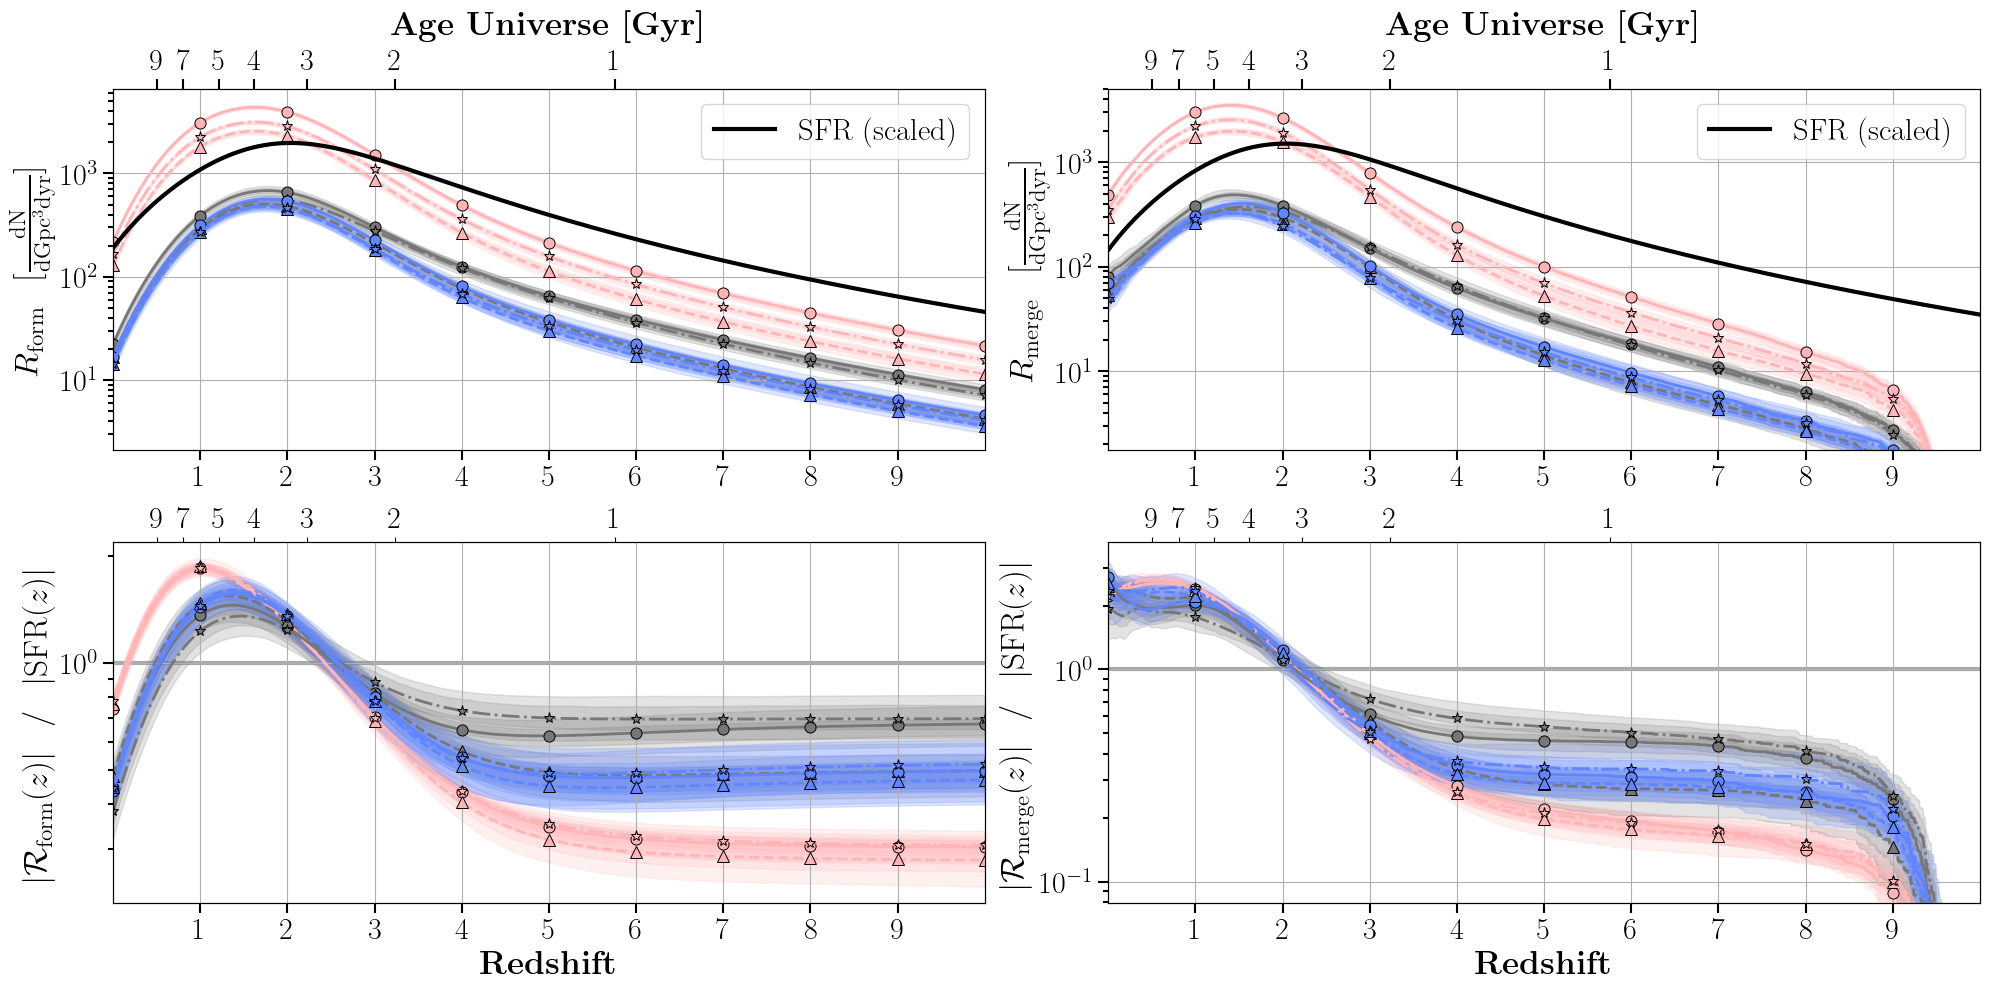

In [20]:
dco_type = 'BNS'
plot_4_panels(redshifts[dco_type], total_formation_rates[dco_type], total_merger_rates[dco_type], one_sigma[dco_type], two_sigma[dco_type], alpha_vals, beta_vals, dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel01_range=(10**0.25, 10**3.7), panel11_range=(10**-1.1, 10**0.6), show_legend=False, figsize=(20,10), bbox_to_anchor=(0.875, 1.25))

# BHNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


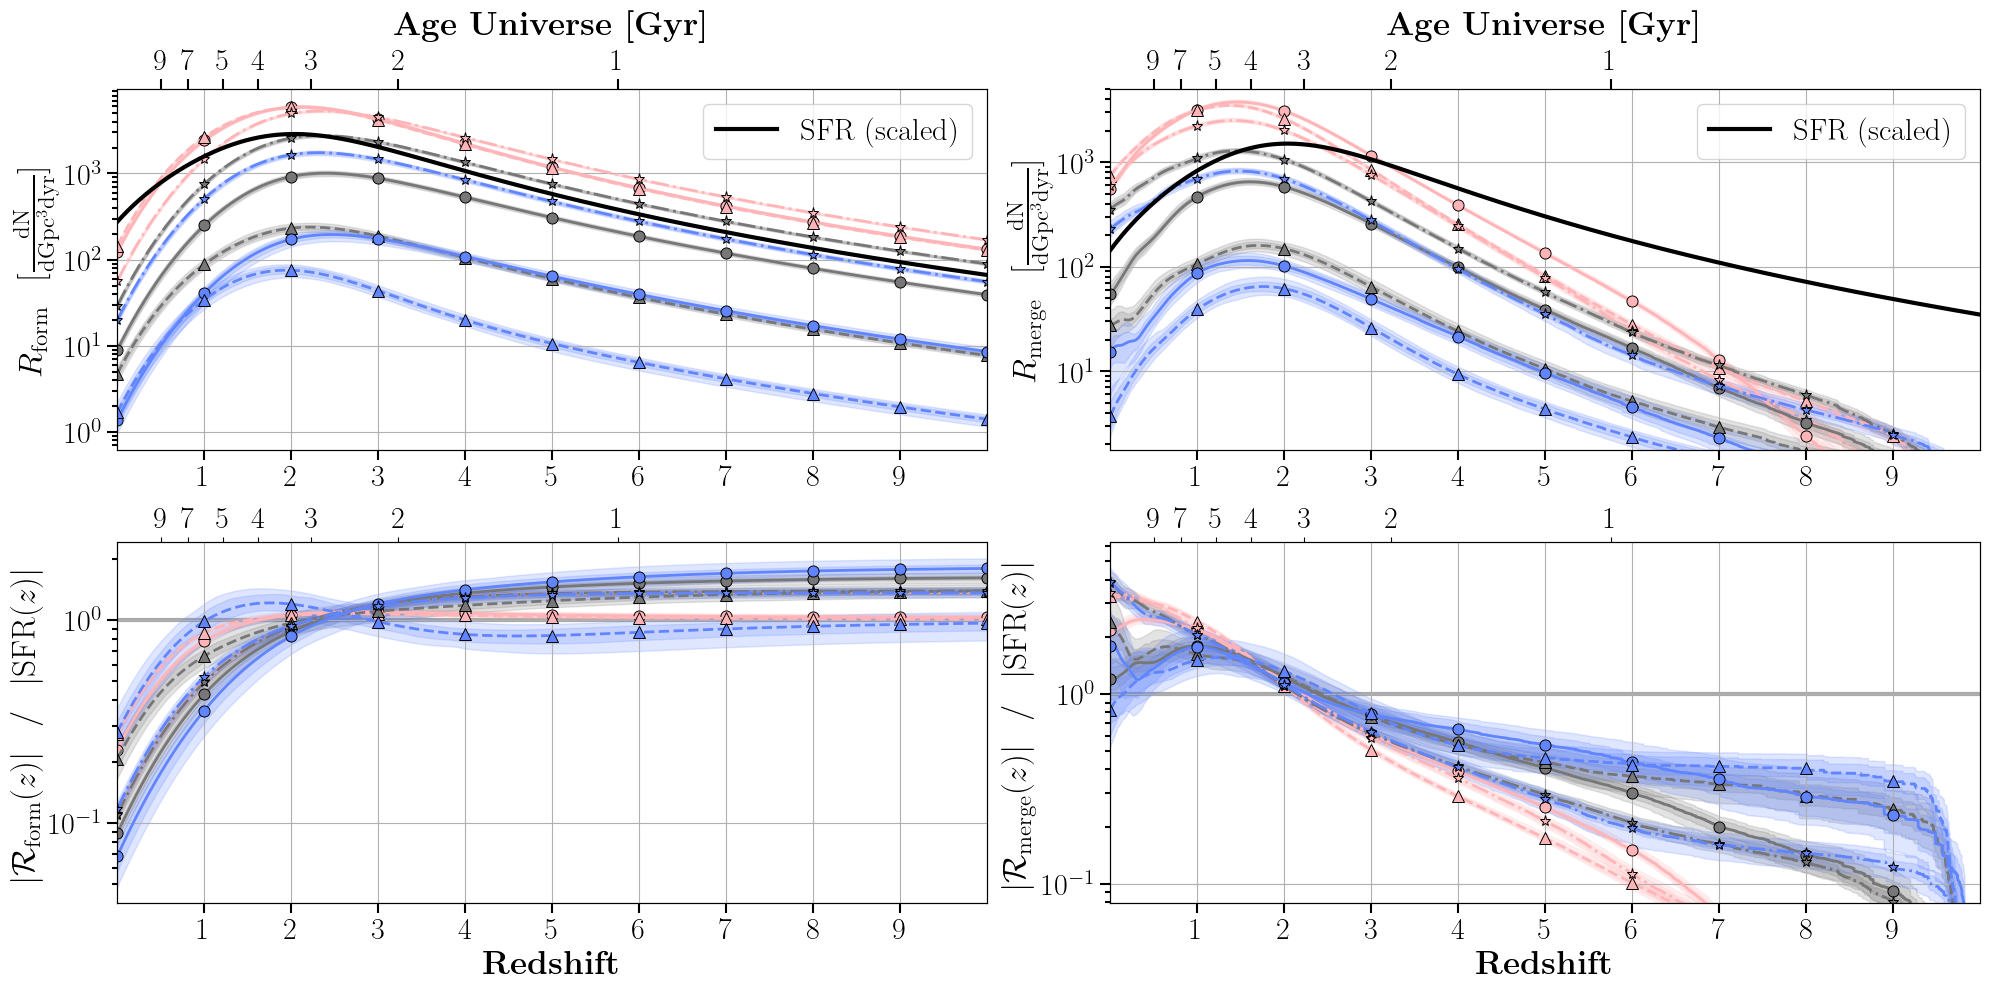

In [21]:
dco_type = 'BHNS'
plot_4_panels(redshifts[dco_type], total_formation_rates[dco_type], total_merger_rates[dco_type], one_sigma[dco_type], two_sigma[dco_type], alpha_vals, beta_vals, dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel01_range=(10**0.25, 10**3.7), panel11_range=(10**-1.1, 10**0.8), show_legend=False, figsize=(20,10), bbox_to_anchor=(0.875, 1.25))

# BHH

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


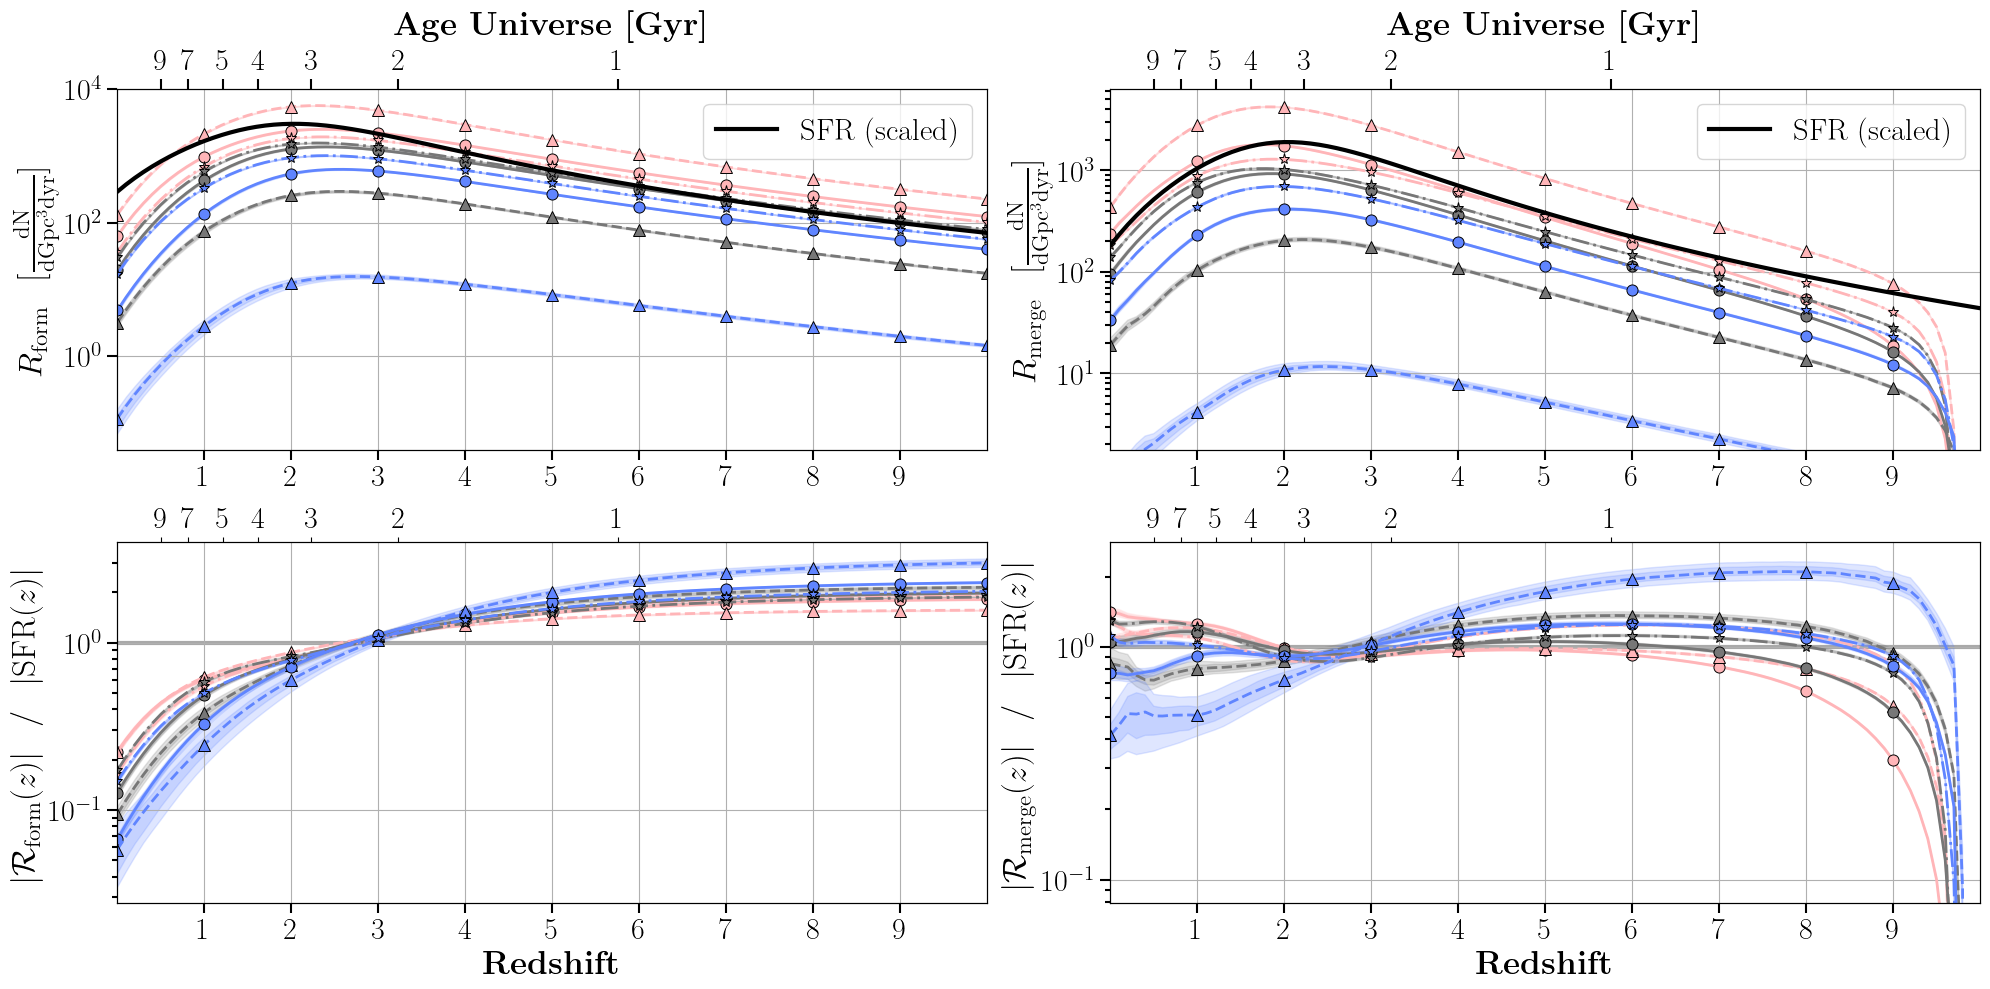

In [22]:
dco_type = 'BBH'
plot_4_panels(redshifts[dco_type], total_formation_rates[dco_type], total_merger_rates[dco_type], one_sigma[dco_type], two_sigma[dco_type], alpha_vals, beta_vals, dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel01_range=(10**0.25, 10**3.8), panel11_range=(10**-1.1, 10**0.45), show_legend=False, figsize=(20,10), bbox_to_anchor=(0.875, 1.25))

In [15]:
def plot_6_panels(redshifts, all_total_merger_rates, one_sigma, two_sigma, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, figsize=(30, 12), show_legend=True, bbox_to_anchor=(0.875, 1.25),
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel00_range=None, panel01_range=None, panel10_range=None, panel11_range=None, panel20_range=None, panel21_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 24
    tickLengthMajor = 7
    tickLengthMinor = 3.5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    
    for i_p, dco_t in enumerate(('BBH', 'BHNS', 'BNS')):
        if dco_t == 'BBH':
            marker_period = 10
        else:
            marker_period = 1000

        # Get redshifts to use for the SFR
        sfr_redshifts = redshifts[dco_t]['30']['D']

        # Retreive the SFR
        MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
        MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
        ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
        sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
        sfr_area = np.trapz(sfr, x=sfr_redshifts)               # Get the area under the curve
        sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1
        
        for alpha_val in alpha_vals:
            for beta_val in beta_vals:
                if i_p == 0:
                    axes[i_p, 0].plot(redshifts[dco_t][alpha_val][beta_val], all_total_merger_rates[dco_t][alpha_val][beta_val], lw=lw, label=r'$\sigma_{\textrm{rms}}^{1D} = $' + alpha_val + r'$\textrm{ RMP} = $' + beta_val, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
                else:
                    axes[i_p, 0].plot(redshifts[dco_t][alpha_val][beta_val], all_total_merger_rates[dco_t][alpha_val][beta_val], lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
                axes[i_p, 0].fill_between(x=redshifts[dco_t][alpha_val][beta_val], y1=one_sigma[dco_t][alpha_val][beta_val]['total_merger_rates'][0], y2=one_sigma[dco_t][alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
                axes[i_p, 0].fill_between(x=redshifts[dco_t][alpha_val][beta_val], y1=two_sigma[dco_t][alpha_val][beta_val]['total_merger_rates'][0], y2=two_sigma[dco_t][alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])

                merger_rate_area = np.trapz(all_total_merger_rates[dco_t][alpha_val][beta_val], x=redshifts[dco_t][alpha_val][beta_val])
                axes[i_p, 1].plot(redshifts[dco_t][alpha_val][beta_val], (all_total_merger_rates[dco_t][alpha_val][beta_val] / merger_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
                axes[i_p, 1].fill_between(x=redshifts[dco_t][alpha_val][beta_val], y1=(one_sigma[dco_t][alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(one_sigma[dco_t][alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
                axes[i_p, 1].fill_between(x=redshifts[dco_t][alpha_val][beta_val], y1=(two_sigma[dco_t][alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(two_sigma[dco_t][alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])

                # Label axes of all the plots
                axes[i_p, 0].set_ylabel(r'\textbf{$R_{\rm{merge}} \ \ [\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
                axes[i_p, 1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)


    # Set lower bounds for the plots
    if panel00_range:
        axes[0, 0].set_ylim(panel00_range)
    if panel01_range:
        axes[0, 1].set_ylim(panel01_range)
    if panel10_range:
        axes[1, 0].set_ylim(panel10_range)
    if panel11_range:
        axes[1, 1].set_ylim(panel11_range)
    if panel20_range:
        axes[2, 0].set_ylim(panel20_range)
    if panel21_range:
        axes[2, 1].set_ylim(panel21_range)
    
    for i_p in range(3):
        # Scale SFR differently for each DCO type
        sfr = sfr/max(sfr)
        merger_const = axes[i_p, 0].get_ylim()[1] * 0.3

        # Plot SFRs
        sfr_line = axes[i_p, 0].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3)
        legend3 = axes[i_p, 0].legend(sfr_line, ["SFR (scaled)"], fontsize=22, loc='upper right')

    axes[2, 0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[2, 1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)
        ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
        ax.set_yscale('log')
        redshift_ticks = np.arange(1, 10, 1)
        ax.xaxis.set_ticks(redshift_ticks)
        ax.set_xlim((0,10))
        ax.grid()

    # Plot horizontal line for SFR on the normalized plots
    axes[0, 1].axhline(y=1, color='darkgray', lw=3, zorder=-1)
    axes[1, 1].axhline(y=1, color='darkgray', lw=3, zorder=-1)
    axes[2, 1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)

    # Include legend
    if show_legend:
        leg = fig.legend(fontsize=22, ncol=3, bbox_to_anchor=bbox_to_anchor,  markerscale=1) 
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3.0)

    # Add lookback time axis
    ax_top1 = add_lookback_t_axes(axes[0, 0], labelsize=fs)
    ax_top2 = add_lookback_t_axes(axes[0, 1], labelsize=fs)
    ax_middle1 = add_lookback_t_axes(axes[1, 0], labelsize=fs, no_label=True)
    ax_middle2 = add_lookback_t_axes(axes[1, 1], labelsize=fs, no_label=True)
    ax_bottom1 = add_lookback_t_axes(axes[2, 0], labelsize=fs, no_label=True)
    ax_bottom2 = add_lookback_t_axes(axes[2, 1], labelsize=fs, no_label=True)
    for ax_top in (ax_top1, ax_top2):
        ax_top.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax_top.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')

    # Show the plot!
    plt.tight_layout()
    plt.show()

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


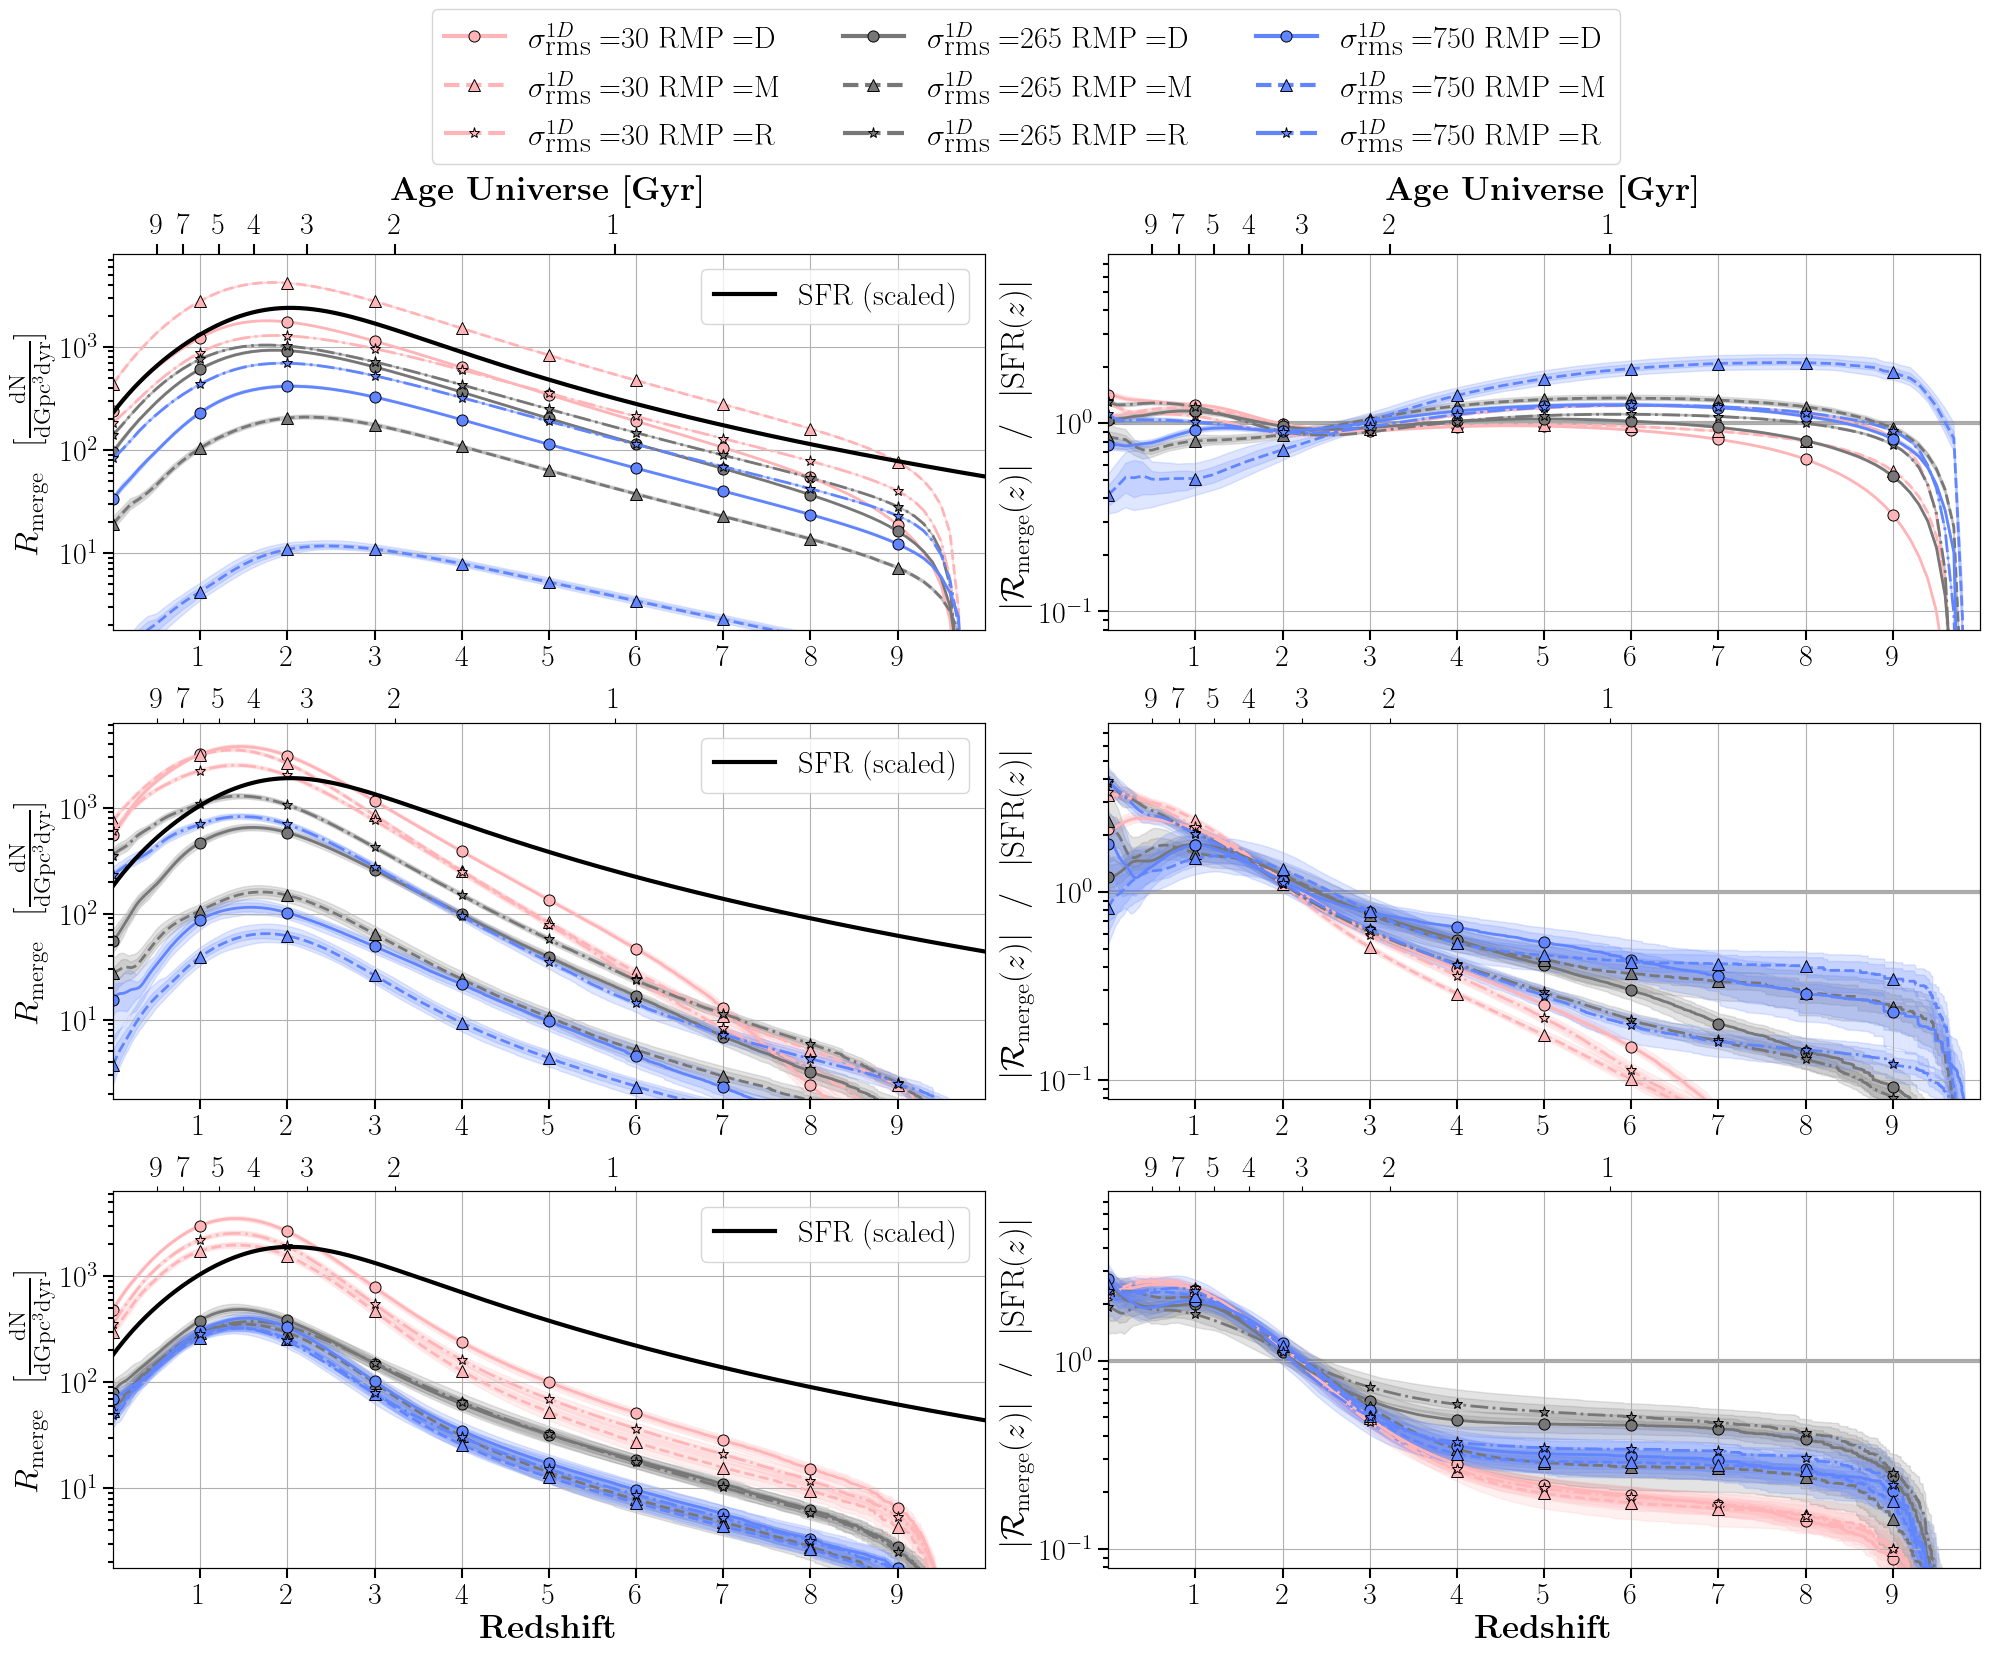

In [23]:
plot_6_panels(redshifts, total_merger_rates, one_sigma, two_sigma, alpha_vals, beta_vals, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel00_range=(10**0.25, 10**3.9), panel10_range=(10**0.25, 10**3.8), panel20_range=(10**0.25, 10**3.8), panel01_range=(10**-1.1, 10**0.9), panel11_range=(10**-1.1, 10**0.9), panel21_range=(10**-1.1, 10**0.9), show_legend=True, figsize=(20,15), bbox_to_anchor=(0.82, 1.11))

# Stats about the spread at z=0, z=4, and z=8

In [17]:
def stats_at_zs(redshifts: dict, total_merger_rates: dict):
    for dco_t in ('BNS', 'BHNS', 'BBH'):
        # Retreive the SFR
        MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
        MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
        ages = MSSFR.cosmology.age(redshifts[dco_t]['30']['D']).value         # Get the ages
        sfr = MSSFR.returnSFR(redshifts[dco_t]['30']['D'], ages)              # Get the SFR
        sfr_area = np.trapz(sfr, x=redshifts[dco_t]['30']['D'])               # Get the area under the curve
        sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1
        
        Rs_off = {'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': []}

        print(f'For {dco_t}: ')
        for z_dicts, R_dicts in zip(redshifts[dco_t].values(), total_merger_rates[dco_t].values()):
            for zd, Rd in zip(z_dicts.values(), R_dicts.values()):
                merger_rate_area = np.trapz(Rd, x=zd)
                Rd_norm = (Rd / merger_rate_area) / sfr_normalized

                for z in range(10):
                    Rs_off[str(z)].append(Rd_norm[zd == z])
        
        print('       min \t\tmedian \t\tmax')
        for z in range(10):
            print(f'$z={z}$  &  {round(min(Rs_off[str(z)])[0], 2)}     &      {round(np.median(Rs_off[str(z)]), 2)}      &      {round(max(Rs_off[str(z)])[0], 2)} \\\\ \\hline')
        print('\n')

In [18]:
stats_at_zs(redshifts, total_merger_rates)

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
For BNS: 
       min 		median 		max
$z=0$  &  1.93     &      2.37      &      2.73 \\ \hline
$z=1$  &  1.76     &      2.21      &      2.43 \\ \hline
$z=2$  &  1.11     &      1.17      &      1.24 \\ \hline
$z=3$  &  0.47     &      0.51      &      0.72 \\ \hline
$z=4$  &  0.26     &      0.34      &      0.59 \\ \hline
$z=5$  &  0.2     &      0.29      &      0.54 \\ \hline
$z=6$  &  0.18     &      0.29      &      0.5 \\ \hline
$z=7$  &  0.16     &      0.28      &      0.47 \\ \hline
$z=8$  &  0.14     &      0.26      &      0.41 \\ \hline
$z=9$  &  0.09     &      0.18      &      0.25 \\ \hline


ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
